In [7]:
import matplotlib.pyplot as plt
import scipy
from scipy import stats
from scipy.stats import norm
import pandas as pd
import numpy as np
import seaborn as sns
from statsmodels.distributions.empirical_distribution import ECDF
from copulae1 import *
from KDEs import *
from toolbox import *
import warnings
import itertools
import os
warnings.filterwarnings("ignore")

data = pd.read_csv('../processed_data/btc_future_crix.csv')
data.head()

ecdf_brr = ECDF(data.return_brr)
ecdf_btc = ECDF(data.return_btc)

u = ecdf_brr(data.return_brr)
v = ecdf_btc(data.return_btc)

brr = np.array(data.return_brr)
btc = np.array(data.return_btc)

kde_brr = KDE(data.return_brr, "Gaussian")
kde_btc = KDE(data.return_btc, "Gaussian")

kde_brr = KDE(data.return_brr, "Gaussian", kde_brr.h_brot*3)
kde_btc = KDE(data.return_brr, "Gaussian", kde_btc.h_brot*3)

In [8]:
# Gaussian, t_Copula, Clayton, Frank, Gumbel, Plackett, Gaussian mix Indep
C1  = Gaussian(dict(rho=0.9),       Law_RS=kde_brr, Law_RF=kde_btc) # fix the maringals!
C2  = t_Copula(dict(rho=0.1, nu=4), Law_RS=kde_brr, Law_RF=kde_btc, nu_lowerbound=2) 
C2c = t_Copula(dict(rho=0.1, nu=4), Law_RS=kde_brr, Law_RF=kde_btc, nu_lowerbound=4) 
C3  = Clayton(dict(theta=0.1),      Law_RS=kde_brr, Law_RF=kde_btc)
C4  = Frank(dict(theta=0.1),        Law_RS=kde_brr, Law_RF=kde_btc)
C5  = Gumbel(dict(theta=3),         Law_RS=kde_brr, Law_RF=kde_btc)
C6  = Plackett(dict(theta=10),      Law_RS=kde_brr, Law_RF=kde_btc)
C7  = Gaussian_Mix_Independent(dict(rho=.5,p=0.7),Law_RS=kde_brr, Law_RF=kde_btc)
Copulae_names = ['Gaussian', 't_Copula', 't_Copula_Capped', 'Clayton', 'Frank', 'Gumbel', 'Plackett', 'Gauss Mix Indep']
Copulae_arr   = [C1,C2,C2c,C3,C4,C5,C6,C7]
Copulae = dict(zip(Copulae_names, Copulae_arr))


In [9]:
data_name = "future_brr_v3"
data_path = "../processed_data/"+data_name+"/"

# Risk Measures
# Variance is automatically included
k_arr = [10,20] # Absolute risk aversion for exponential risk measure
q_arr_ES = [0.01,0.05,0.1] # Quantile level for expected shortfall

spot_name = "log return brr"
future_name = "log return future"

paras_results = []
likelihood_results = []
best_h_results = []

calibration_method = "MM" # MM or MLE
q_arr = [0.05,0.1,0.9,0.95]

ls = os.listdir(data_path+'train/')
ls = [l for l in ls if l.endswith('.csv')]
for file in ls:
    # Calibration 
    train = pd.read_csv(data_path+'train/'+file)
    spot   = train.loc[:,spot_name]
    future = train.loc[:,future_name]
    u = ECDF(spot)(spot)
    v = ECDF(future)(future)
    
    kde_brr = KDE(spot, "Gaussian")
    kde_btc = KDE(future, "Gaussian")
    
    for C_name in Copulae:
        Copulae[C_name].Law_RS = kde_brr
        Copulae[C_name].Law_RF = kde_btc
    
    paras = []
    likelihood = []
    best_h = []
    for C_name in Copulae:
        if calibration_method == "MLE":
            Copulae[C_name].canonical_calibrate(u,v)
            
        elif calibration_method == "MM":
            Copulae[C_name].mm_calibrate(u,v,q_arr)

        print(C_name,'is done.\n')
    
    for C_name in Copulae:
        paras.append((C_name,Copulae[C_name].paras))
        
    for C_name in Copulae:
        ln = Copulae[C_name].dependency_likelihood(u,v)
        likelihood.append((C_name,ln))
        
    paras_results.append(paras)
    likelihood_results.append(likelihood)
    
    # Get Best h
    best_h = []
    for C_name in Copulae:
        best_h.append(optimize_h(Copulae[C_name], k_arr, q_arr_ES))
    best_h = pd.DataFrame(best_h)
    best_h.columns = ['Var'] + ['ERM k=%i'%k for k in k_arr] +  ['ES q=%.2f'%q for q in q_arr_ES]
    best_h.index = Copulae_names 
    best_h_results.append(best_h)
    
#     # Testing
#     test = pd.read_csv(data_path+'test/'+file)
#     spot_test   = train.loc[:,spot_name]
#     future_test = train.loc[:,future_name]

Optimization terminated successfully.
         Current function value: 0.020007
         Iterations: 33
         Function evaluations: 68
Gaussian is done.

Optimization terminated successfully.
         Current function value: 0.011028
         Iterations: 128
         Function evaluations: 264
t_Copula is done.

Optimization terminated successfully.
         Current function value: 0.012225
         Iterations: 170
         Function evaluations: 328
t_Copula_Capped is done.

Optimization terminated successfully.
         Current function value: 0.350726
         Iterations: 44
         Function evaluations: 96
Clayton is done.

Optimization terminated successfully.
         Current function value: 0.100847
         Iterations: 48
         Function evaluations: 110
Frank is done.

Optimization terminated successfully.
         Current function value: 0.080658
         Iterations: 35
         Function evaluations: 76
Gumbel is done.

Optimization terminated successfully.
         Curre

Optimization terminated successfully.
         Current function value: 0.016778
         Iterations: 133
         Function evaluations: 252
t_Copula_Capped is done.

Optimization terminated successfully.
         Current function value: 0.213357
         Iterations: 34
         Function evaluations: 74
Clayton is done.

Optimization terminated successfully.
         Current function value: 0.097436
         Iterations: 38
         Function evaluations: 84
Frank is done.

Optimization terminated successfully.
         Current function value: 0.151122
         Iterations: 33
         Function evaluations: 72
Gumbel is done.

Optimization terminated successfully.
         Current function value: 0.045624
         Iterations: 40
         Function evaluations: 89
Plackett is done.

Optimization terminated successfully.
         Current function value: 0.018396
         Iterations: 67
         Function evaluations: 138
Gauss Mix Indep is done.

Optimization terminated successfully.
         

Optimization terminated successfully.
         Current function value: 0.010977
         Iterations: 65
         Function evaluations: 140
Gauss Mix Indep is done.

Optimization terminated successfully.
         Current function value: 0.000610
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: 0.037762
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: 0.052173
         Iterations: 13
         Function evaluations: 26
Optimization terminated successfully.
         Current function value: 0.009951
         Iterations: 15
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 0.000644
         Iterations: 14
         Function evaluations: 29
Optimization terminated successfully.
         Current function value: -0.000566
         Iterations: 15
         Function evaluations: 31
Optimi

Optimization terminated successfully.
         Current function value: 0.039235
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: 0.054346
         Iterations: 13
         Function evaluations: 26
Optimization terminated successfully.
         Current function value: 0.010173
         Iterations: 14
         Function evaluations: 29
Optimization terminated successfully.
         Current function value: 0.001361
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 0.000200
         Iterations: 17
         Function evaluations: 36
Optimization terminated successfully.
         Current function value: 0.000650
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: 0.040668
         Iterations: 14
         Function evaluations: 28
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 0.000092
         Iterations: 14
         Function evaluations: 29
Optimization terminated successfully.
         Current function value: -0.002295
         Iterations: 15
         Function evaluations: 31
Optimization terminated successfully.
         Current function value: 0.000598
         Iterations: 12
         Function evaluations: 24
Optimization terminated successfully.
         Current function value: 0.036834
         Iterations: 12
         Function evaluations: 24
Optimization terminated successfully.
         Current function value: 0.052551
         Iterations: 12
         Function evaluations: 24
Optimization terminated successfully.
         Current function value: 0.008109
         Iterations: 13
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: 0.000466
         Iterations: 14
         Function evaluations: 30
Optimization terminated successfu

Optimization terminated successfully.
         Current function value: 0.035112
         Iterations: 13
         Function evaluations: 26
Optimization terminated successfully.
         Current function value: 0.050110
         Iterations: 13
         Function evaluations: 26
Optimization terminated successfully.
         Current function value: 0.007601
         Iterations: 13
         Function evaluations: 29
Optimization terminated successfully.
         Current function value: -0.000454
         Iterations: 15
         Function evaluations: 31
Optimization terminated successfully.
         Current function value: -0.002921
         Iterations: 18
         Function evaluations: 38
Optimization terminated successfully.
         Current function value: 0.000461
         Iterations: 13
         Function evaluations: 26
Optimization terminated successfully.
         Current function value: 0.033745
         Iterations: 13
         Function evaluations: 26
Optimization terminated successf

Optimization terminated successfully.
         Current function value: 0.000079
         Iterations: 16
         Function evaluations: 36
Optimization terminated successfully.
         Current function value: -0.001276
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 0.000559
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: 0.037013
         Iterations: 13
         Function evaluations: 26
Optimization terminated successfully.
         Current function value: 0.051640
         Iterations: 13
         Function evaluations: 26
Optimization terminated successfully.
         Current function value: 0.009275
         Iterations: 14
         Function evaluations: 29
Optimization terminated successfully.
         Current function value: 0.000084
         Iterations: 16
         Function evaluations: 35
Optimization terminated successfu

Optimization terminated successfully.
         Current function value: 0.036626
         Iterations: 13
         Function evaluations: 26
Optimization terminated successfully.
         Current function value: 0.051542
         Iterations: 13
         Function evaluations: 26
Optimization terminated successfully.
         Current function value: 0.008822
         Iterations: 15
         Function evaluations: 33
Optimization terminated successfully.
         Current function value: -0.000554
         Iterations: 17
         Function evaluations: 37
Optimization terminated successfully.
         Current function value: -0.002293
         Iterations: 17
         Function evaluations: 36
Optimization terminated successfully.
         Current function value: 0.000383
         Iterations: 13
         Function evaluations: 26
Optimization terminated successfully.
         Current function value: 0.027374
         Iterations: 14
         Function evaluations: 28
Optimization terminated successf

Optimization terminated successfully.
         Current function value: 0.001875
         Iterations: 13
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: -0.000294
         Iterations: 13
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: 0.000692
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: 0.037147
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: 0.046182
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: 0.011913
         Iterations: 16
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 0.002625
         Iterations: 12
         Function evaluations: 26
Optimization terminated successfu

Optimization terminated successfully.
         Current function value: 0.020449
         Iterations: 13
         Function evaluations: 26
Optimization terminated successfully.
         Current function value: 0.027467
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: 0.003274
         Iterations: 10
         Function evaluations: 22
Optimization terminated successfully.
         Current function value: 0.000993
         Iterations: 12
         Function evaluations: 26
Optimization terminated successfully.
         Current function value: -0.000020
         Iterations: 15
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 0.000337
         Iterations: 13
         Function evaluations: 26
Optimization terminated successfully.
         Current function value: 0.030260
         Iterations: 13
         Function evaluations: 26
Optimization terminated successfu

Optimization terminated successfully.
         Current function value: 0.001122
         Iterations: 12
         Function evaluations: 25
Optimization terminated successfully.
         Current function value: 0.000289
         Iterations: 14
         Function evaluations: 31
Optimization terminated successfully.
         Current function value: 0.000451
         Iterations: 13
         Function evaluations: 26
Optimization terminated successfully.
         Current function value: 0.031248
         Iterations: 13
         Function evaluations: 26
Optimization terminated successfully.
         Current function value: 0.045370
         Iterations: 13
         Function evaluations: 26
Optimization terminated successfully.
         Current function value: 0.005204
         Iterations: 13
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: 0.001625
         Iterations: 14
         Function evaluations: 31
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 0.031170
         Iterations: 13
         Function evaluations: 26
Optimization terminated successfully.
         Current function value: 0.044347
         Iterations: 13
         Function evaluations: 26
Optimization terminated successfully.
         Current function value: 0.005319
         Iterations: 13
         Function evaluations: 27
Optimization terminated successfully.
         Current function value: 0.002004
         Iterations: 12
         Function evaluations: 25
Optimization terminated successfully.
         Current function value: 0.000321
         Iterations: 11
         Function evaluations: 25
Optimization terminated successfully.
         Current function value: 0.000423
         Iterations: 13
         Function evaluations: 26
Optimization terminated successfully.
         Current function value: 0.033414
         Iterations: 12
         Function evaluations: 24
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 0.001009
         Iterations: 14
         Function evaluations: 30
Optimization terminated successfully.
         Current function value: -0.000846
         Iterations: 16
         Function evaluations: 33
Optimization terminated successfully.
         Current function value: 0.000312
         Iterations: 13
         Function evaluations: 26
Optimization terminated successfully.
         Current function value: 0.026614
         Iterations: 13
         Function evaluations: 26
Optimization terminated successfully.
         Current function value: 0.036347
         Iterations: 13
         Function evaluations: 26
Optimization terminated successfully.
         Current function value: 0.005324
         Iterations: 13
         Function evaluations: 26
Optimization terminated successfully.
         Current function value: -0.000244
         Iterations: 15
         Function evaluations: 32
Optimization terminated successf

Optimization terminated successfully.
         Current function value: 0.033784
         Iterations: 13
         Function evaluations: 26
Optimization terminated successfully.
         Current function value: 0.045854
         Iterations: 13
         Function evaluations: 26
Optimization terminated successfully.
         Current function value: 0.008151
         Iterations: 14
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 0.000553
         Iterations: 14
         Function evaluations: 29
Optimization terminated successfully.
         Current function value: -0.000701
         Iterations: 15
         Function evaluations: 30
Optimization terminated successfully.
         Current function value: 0.000531
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: 0.033691
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfu

Optimization terminated successfully.
         Current function value: 0.001054
         Iterations: 16
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: -0.000643
         Iterations: 16
         Function evaluations: 33
Optimization terminated successfully.
         Current function value: 0.000597
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: 0.035569
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: 0.049870
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: 0.007522
         Iterations: 15
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 0.002143
         Iterations: 15
         Function evaluations: 33
Optimization terminated successfu

Optimization terminated successfully.
         Current function value: 0.031583
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: 0.044830
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: 0.006247
         Iterations: 14
         Function evaluations: 30
Optimization terminated successfully.
         Current function value: 0.001365
         Iterations: 15
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: -0.000356
         Iterations: 15
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 0.000926
         Iterations: 15
         Function evaluations: 30
Optimization terminated successfully.
         Current function value: 0.044077
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfu

Optimization terminated successfully.
         Current function value: 0.002289
         Iterations: 15
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 0.000168
         Iterations: 15
         Function evaluations: 33
Optimization terminated successfully.
         Current function value: 0.001106
         Iterations: 15
         Function evaluations: 30
Optimization terminated successfully.
         Current function value: 0.048784
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: 0.068001
         Iterations: 15
         Function evaluations: 30
Optimization terminated successfully.
         Current function value: 0.009050
         Iterations: 13
         Function evaluations: 26
Optimization terminated successfully.
         Current function value: 0.003835
         Iterations: 16
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 0.046223
         Iterations: 15
         Function evaluations: 30
Optimization terminated successfully.
         Current function value: 0.063273
         Iterations: 15
         Function evaluations: 30
Optimization terminated successfully.
         Current function value: 0.009398
         Iterations: 13
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: 0.003825
         Iterations: 14
         Function evaluations: 31
Optimization terminated successfully.
         Current function value: 0.000712
         Iterations: 17
         Function evaluations: 35
Optimization terminated successfully.
         Current function value: 0.034624
         Iterations: 31
         Function evaluations: 65
Gaussian is done.

Optimization terminated successfully.
         Current function value: 0.019023
         Iterations: 101
         Function evaluations: 192
t_Copula is d

Optimization terminated successfully.
         Current function value: 0.004195
         Iterations: 15
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 0.001020
         Iterations: 16
         Function evaluations: 33
Optimization terminated successfully.
         Current function value: 0.074080
         Iterations: 31
         Function evaluations: 66
Gaussian is done.

Optimization terminated successfully.
         Current function value: 0.057304
         Iterations: 122
         Function evaluations: 225
t_Copula is done.

Optimization terminated successfully.
         Current function value: 0.062315
         Iterations: 131
         Function evaluations: 247
t_Copula_Capped is done.

Optimization terminated successfully.
         Current function value: 0.577094
         Iterations: 36
         Function evaluations: 82
Clayton is done.

Optimization terminated successfully.
         Current function value: 0.169479
      

Optimization terminated successfully.
         Current function value: 0.055217
         Iterations: 133
         Function evaluations: 259
t_Copula is done.

Optimization terminated successfully.
         Current function value: 0.063121
         Iterations: 130
         Function evaluations: 248
t_Copula_Capped is done.

Optimization terminated successfully.
         Current function value: 0.570970
         Iterations: 37
         Function evaluations: 82
Clayton is done.

Optimization terminated successfully.
         Current function value: 0.176621
         Iterations: 37
         Function evaluations: 84
Frank is done.

Optimization terminated successfully.
         Current function value: 0.052787
         Iterations: 33
         Function evaluations: 70
Gumbel is done.

Optimization terminated successfully.
         Current function value: 0.106663
         Iterations: 39
         Function evaluations: 89
Plackett is done.

Optimization terminated successfully.
         Curren

Optimization terminated successfully.
         Current function value: 0.060523
         Iterations: 62
         Function evaluations: 133
Gauss Mix Indep is done.

Optimization terminated successfully.
         Current function value: 0.000584
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: 0.033442
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: 0.043737
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: 0.009606
         Iterations: 14
         Function evaluations: 30
Optimization terminated successfully.
         Current function value: 0.000974
         Iterations: 14
         Function evaluations: 30
Optimization terminated successfully.
         Current function value: -0.001579
         Iterations: 15
         Function evaluations: 32
Optimi

Optimization terminated successfully.
         Current function value: 0.057536
         Iterations: 13
         Function evaluations: 26
Optimization terminated successfully.
         Current function value: 0.013804
         Iterations: 15
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 0.002534
         Iterations: 14
         Function evaluations: 29
Optimization terminated successfully.
         Current function value: 0.000103
         Iterations: 16
         Function evaluations: 33
Optimization terminated successfully.
         Current function value: 0.001038
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: 0.048281
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: 0.065507
         Iterations: 14
         Function evaluations: 28
Optimization terminated successful

Optimization terminated successfully.
         Current function value: -0.000361
         Iterations: 14
         Function evaluations: 29
Optimization terminated successfully.
         Current function value: 0.000948
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: 0.046226
         Iterations: 13
         Function evaluations: 26
Optimization terminated successfully.
         Current function value: 0.063815
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: 0.013058
         Iterations: 14
         Function evaluations: 29
Optimization terminated successfully.
         Current function value: 0.002351
         Iterations: 14
         Function evaluations: 31
Optimization terminated successfully.
         Current function value: 0.000106
         Iterations: 16
         Function evaluations: 35
Optimization terminated successfu

In [10]:
s = Copulae[C_name].sample(10000000)

In [12]:
u2[u2<0] 

NameError: name 'u2' is not defined

In [13]:
c_arr = []
date_range_arr = []
for i, file in enumerate(ls):
    train = pd.read_csv(data_path+'train/'+file)
    date_range = train.Date.iloc[-1] +' to ' + train.Date.iloc[0]
    date_range_arr.append(date_range)
    
    c = pd.DataFrame(paras_results[i])
    c.index = c.iloc[:,0]
    c = pd.DataFrame(c.iloc[:,1])
#     c.columns = ['paras']
    c_arr.append(c)
    
paras_results_pd = pd.concat(dict(zip(ls, c_arr)), axis=1)
paras_results_pd.columns = paras_results_pd.columns.droplevel(1)
paras_results_pd.index.name= None

l_arr = []
date_range_arr = []
for i, file in enumerate(ls):
    train = pd.read_csv(data_path+'train/'+file)
    date_range = train.Date.iloc[-1] +' to ' + train.Date.iloc[0]
    date_range_arr.append(date_range)
    
    c = pd.DataFrame(likelihood_results[i])
    c.index = c.iloc[:,0]
    c = pd.DataFrame(c.iloc[:,1])
#     c.columns = ['likelihood']
    l_arr.append(c)
    
likelihood_results_pd = pd.concat(dict(zip(ls, l_arr)), axis=1)
likelihood_results_pd.columns = likelihood_results_pd.columns.droplevel(1)
likelihood_results_pd.index.name= None

In [14]:
paras_results_pd

,0.csv,1.csv,10.csv,11.csv,12.csv,13.csv,14.csv,15.csv,16.csv,17.csv,...,21.csv,22.csv,23.csv,3.csv,4.csv,5.csv,6.csv,7.csv,8.csv,9.csv
Gaussian,{'rho': 0.9225855934221066},{'rho': 0.8990342364245347},{'rho': 0.8543387025973579},{'rho': 0.8495890279602043},{'rho': 0.8490482103724881},{'rho': 0.8562696986194751},{'rho': 0.866091775980661},{'rho': 0.8748681452428393},{'rho': 0.8820039269415618},{'rho': 0.9002557399037203},...,{'rho': 0.8721750257512891},{'rho': 0.8805020224388305},{'rho': 0.822187347971723},{'rho': 0.8328417584788887},{'rho': 0.8245662000298476},{'rho': 0.832327253380944},{'rho': 0.829786535538733},{'rho': 0.805445664681918},{'rho': 0.8594992028443169},{'rho': 0.8421395183863892}
t_Copula,"{'rho': 0.8795572960434375, 'nu': 2.0000000000...","{'rho': 0.8537717029850787, 'nu': 2.3137015642...","{'rho': 0.7786393030921652, 'nu': 2.0000000000...","{'rho': 0.7715192990886556, 'nu': 2.0000000000...","{'rho': 0.7705516829408195, 'nu': 2.0000000000...","{'rho': 0.7794957665033438, 'nu': 2.0000000000...","{'rho': 0.7946802520401435, 'nu': 2.0000000000...","{'rho': 0.8074775156580685, 'nu': 2.0000000000...","{'rho': 0.8166903947933413, 'nu': 2.0000000000...","{'rho': 0.844547936485667, 'nu': 2.00000000000...",...,"{'rho': 0.804588079162528, 'nu': 2.00000000000...","{'rho': 0.817929104732943, 'nu': 2.00000000000...","{'rho': 0.817807465575295, 'nu': 37.9441792073...","{'rho': 0.7989025411707685, 'nu': 4.8410263287...","{'rho': 0.7881664603670131, 'nu': 4.7234827892...","{'rho': 0.7663982966337461, 'nu': 2.5608539844...","{'rho': 0.760589160710403, 'nu': 2.47545673862...","{'rho': 0.742353111880943, 'nu': 3.04734623951...","{'rho': 0.7866715627313539, 'nu': 2.0000000000...","{'rho': 0.774006513281639, 'nu': 2.34786453127..."
t_Copula_Capped,"{'rho': 0.9011635670623568, 'nu': 4.0000000000...","{'rho': 0.8729084407366408, 'nu': 4.0000000000...","{'rho': 0.8161378494912127, 'nu': 4.0000000000...","{'rho': 0.8100154058790563, 'nu': 4.0000000000...","{'rho': 0.8092656230286966, 'nu': 4.0000000000...","{'rho': 0.8175672115502138, 'nu': 4.0000000000...","{'rho': 0.8301432625280927, 'nu': 4.0000000000...","{'rho': 0.8410660111730215, 'nu': 4.0000000000...","{'rho': 0.8492949399616989, 'nu': 4.0000000000...","{'rho': 0.8725082504072074, 'nu': 4.0000000000...",...,"{'rho': 0.8383005394570953, 'nu': 4.0000000000...","{'rho': 0.8491552788697256, 'nu': 4.0000000000...","{'rho': 0.8178074732485221, 'nu': 37.944256230...","{'rho': 0.7989025501609011, 'nu': 4.8410265494...","{'rho': 0.7881664579240765, 'nu': 4.7234820586...","{'rho': 0.7899214219453529, 'nu': 4.0000000000...","{'rho': 0.7867021886738246, 'nu': 4.0000000000...","{'rho': 0.7572959211572363, 'nu': 4.0000000000...","{'rho': 0.8226313897856339, 'nu': 4.0000000000...","{'rho': 0.8019054063982395, 'nu': 4.0000000000..."
Clayton,{'theta': 23.709029752170686},{'theta': 21.39257410231784},{'theta': 11.401216362026936},{'theta': 10.661715956221094},{'theta': 10.476652991063375},{'theta': 13.098190386636002},{'theta': 19.256814940447455},{'theta': 21.85824902678678},{'theta': 26.717615080547347},{'theta': 24.50332437453641},...,{'theta': 12.937095166910172},{'theta': 13.893939329554499},{'theta': 2.7702621796734137},{'theta': 3.728530131410632},{'theta': 3.1344754412144207},{'theta': 3.1954419147842},{'theta': 2.7209118545055486},{'theta': 2.34097023362352},{'theta': 9.019454383489247},{'theta': 4.255171151360024}
Frank,{'theta': 30.972540601731726},{'theta': 24.853749363226463},{'theta': 18.114867102978828},{'theta': 17.5328527269728},{'theta': 17.483516981118687},{'theta': 18.52977522465477},{'theta': 19.785802808940748},{'theta': 21.142300123112953},{'theta': 22.327782217438344},{'theta': 25.816498127179813},...,{'theta': 20.7920642055788},{'theta': 21.946083945901023},{'theta': 15.256155929543976},{'theta': 15.846403201728679},{'theta': 15.081257461677557},{'theta': 15.700809784256212},{'theta': 15.477656250298079},{'theta': 13.544044285583048},{'theta': 18.703948065967435},{'theta

In [15]:
likelihood_results_pd

,0.csv,1.csv,10.csv,11.csv,12.csv,13.csv,14.csv,15.csv,16.csv,17.csv,...,21.csv,22.csv,23.csv,3.csv,4.csv,5.csv,6.csv,7.csv,8.csv,9.csv
Gaussian,0.382146,0.447627,0.330116,0.299147,0.286967,0.214589,0.231070,0.170225,0.140504,0.096343,...,0.209534,0.264415,0.365129,0.487001,0.442334,0.407663,0.398796,0.350865,0.360643,0.375856
t_Copula,0.608672,0.615151,0.490822,0.463958,0.466306,0.423038,0.443190,0.449892,0.484917,0.528380,...,0.471408,0.516270,0.388911,0.537296,0.507320,0.485757,0.469366,0.429936,0.488210,0.501469
t_Copula_Capped,0.592766,0.605069,0.475735,0.451189,0.449072,0.401734,0.422849,0.418552,0.444013,0.480339,...,0.433917,0.482868,0.388911,0.537296,0.507320,0.482980,0.468165,0.426911,0.484223,0.490619
Clayton,-4.345719,-4.166837,-1.827141,-1.840727,-1.862528,-3.171704,-5.485305,-6.588074,-8.494909,-6.721148,...,-2.269631,-2.303446,0.342852,0.370110,0.446927,0.355594,0.379234,0.357579,-0.946627,0.148313
Frank,-0.790507,-0.318014,-0.107476,-0.072256,-0.081495,-0.344522,-0.357248,-0.489982,-0.551753,-0.763104,...,-0.522039,-0.486329,-0.001756,0.148016,0.183655,0.093154,0.078880,0.138822,-0.087001,0.026740
Gumbel,0.359223,0.498663,0.384776,0.379893,0.385101,0.332634,0.356786,0.336942,0.408189,0.383970,...,0.303925,0.358010,0.404174,0.433012,0.415945,0.390762,0.374703,0.339500,0.369199,0.412672
Plackett,0.394614,0.476551,0.420756,0.420054,0.425499,0.323059,0.353600,0.357094,0.394175,0.413378,...,0.356378,0.396348,0.405335,0.472512,0.469115,0.424984,0.406131,0.399133,0.418020,0.449103
Gauss Mix Indep,0.249699,0.504187,0.428955,0.411885,0.420177,0.217484,0.268344,0.220409,0.151748,-0.038806,...,0.271838,0.408490,0.461169,0.528987,0.510281,0.455236,0.427138,0.417915,0.428037,0.484137


In [16]:
best_h_results_pd = pd.concat(dict(zip(ls, best_h_results)), axis=1)

In [17]:
def cap(h):
    if h < 0:
        return 0
    elif h >1:
        return 1
    else:
        return h

In [18]:
columns = best_h_results_pd.columns
for c in columns:
     best_h_results_pd.loc[:,c] = best_h_results_pd.loc[:,c].apply(cap)

In [19]:
def hedging_effectiveness(h_arr, spot, future, k_arr, q_arr):
    results = np.ones((len(h_arr),1+len(k_arr)+len(q_arr)))
    for i, h in enumerate(h_arr):
        rh = spot-h*future
        results[i,:]=1-risk_measures(k_arr, q_arr, rh)/risk_measures(k_arr, q_arr, spot)
    return np.array([results[i,i] for i in range(len(h_arr))])

In [20]:
date_range_arr = []
for i, file in enumerate(ls):
    train = pd.read_csv(data_path+'train/'+file)
    date_range = train.Date.iloc[-1] +' to ' + train.Date.iloc[0]
    date_range_arr.append(date_range)

In [21]:
display_likelihood = likelihood_results_pd.copy()
display_likelihood.columns = date_range_arr
display_likelihood = display_likelihood.reindex(sorted(display_likelihood.columns), axis=1)

In [22]:
display_paras = paras_results_pd.copy()
display_paras.columns = date_range_arr
display_paras = display_paras.reindex(sorted(display_paras.columns), axis=1)

In [23]:
display_best_h = best_h_results_pd.copy()
display_best_h.columns.set_levels(date_range_arr, level=0, inplace=True)
display_best_h = display_best_h.reindex(sorted(display_best_h.columns), axis=1)

In [24]:
if os.path.exists("../results/" + data_name)==False:
    print("Create new folder for results")
    os.mkdir("../results/" + data_name)
    os.mkdir("../results/" + data_name +"/MLE")
    os.mkdir("../results/" + data_name +"/MM")
    
if calibration_method == "MLE":
    path = "../results/"+ data_name +"/MLE/"
    paras_results_pd.to_json(path+"parameters.json")
    likelihood_results_pd.to_json(path+"likelihood.json")
    best_h_results_pd.to_json(path+"best_h.json")
    
    display_paras.to_html(path+"paras.html")
    display_likelihood.to_html(path+"likelihood.html")
    display_best_h.to_html(path+"best_h.html")

    
elif calibration_method == "MM":
    path = "../results/"+ data_name +"/MM/"
    paras_results_pd.to_json(path+"parameters.json")
    likelihood_results_pd.to_json(path+"likelihood.json")
    best_h_results_pd.to_json(path+"best_h.json")
    
    display_paras.to_html(path+"paras.html")
    display_likelihood.to_html(path+"likelihood.html")
    display_best_h.to_html(path+"best_h.html")

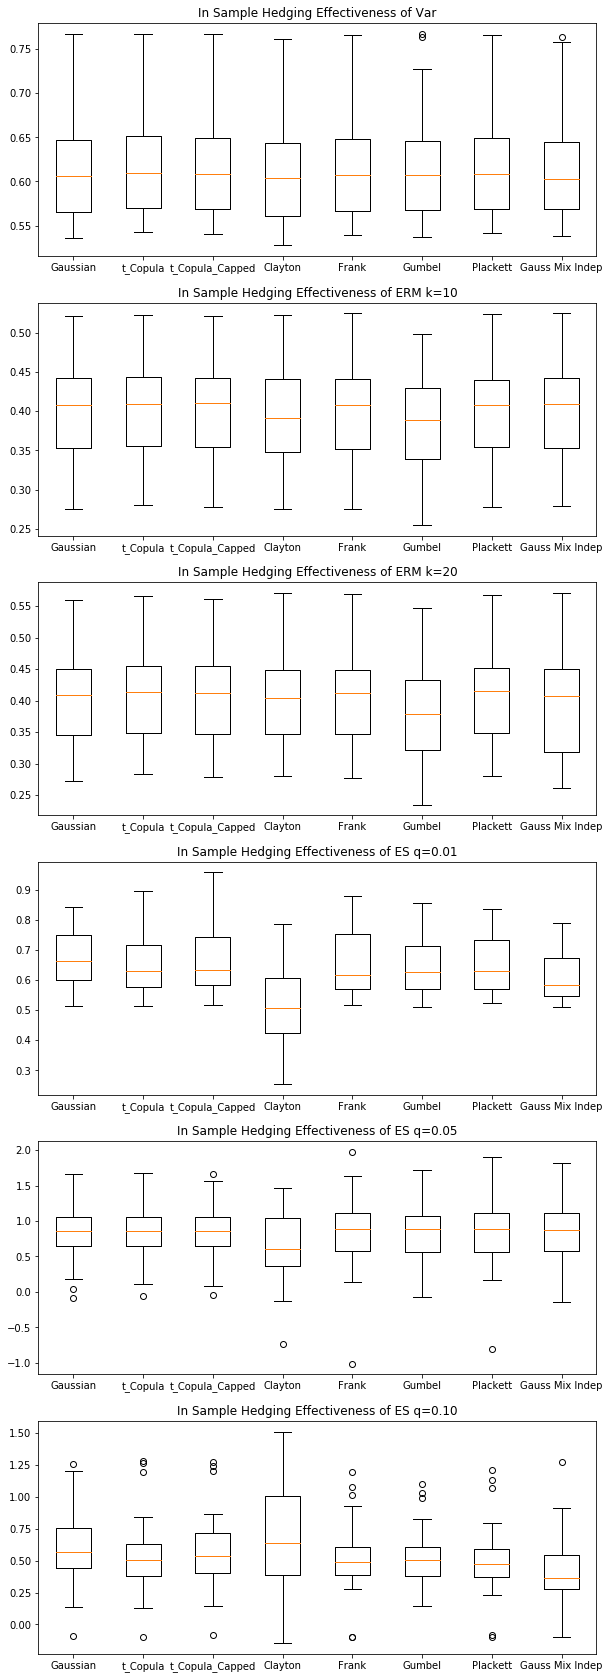

In [25]:
HE_results = []

for i, file in enumerate(ls):
    test = pd.read_csv(data_path+'train/'+file)
    spot   = test.loc[:,spot_name]
    future = test.loc[:,future_name]
    fn = lambda h_arr: hedging_effectiveness(h_arr, spot, future, k_arr, q_arr)
    HE = pd.DataFrame().reindex_like(best_h_results[0])
    HEs = best_h_results[i].apply(fn, axis=1)
    for i in range(len(HEs)):
        HE.iloc[i,:] = HEs[i]
    HE_results.append(HE)
HE_results_pd = pd.concat(dict(zip(ls, HE_results)), axis=1)
risk_measure_names = HE_results_pd.droplevel(0,axis=1).columns.unique()

fig, ax = plt.subplots(len(risk_measure_names), 1, figsize=(10,5*len(risk_measure_names)))
for i, name in enumerate(risk_measure_names): 
    ax[i].boxplot(HE_results_pd.droplevel(0,axis=1).loc[:,name])
    ax[i].set_xticklabels(Copulae_names)
    ax[i].set_title("In Sample Hedging Effectiveness of %s"%name)
    
if calibration_method == "MLE":
    fig.savefig("../results/"+ data_name +"/MLE/"+"In Sample Hedging Effectiveness.png", transparent=True)    
elif calibration_method == "MM":
    fig.savefig("../results/"+ data_name +"/MM/"+"In Sample Hedging Effectiveness.png", transparent=True)

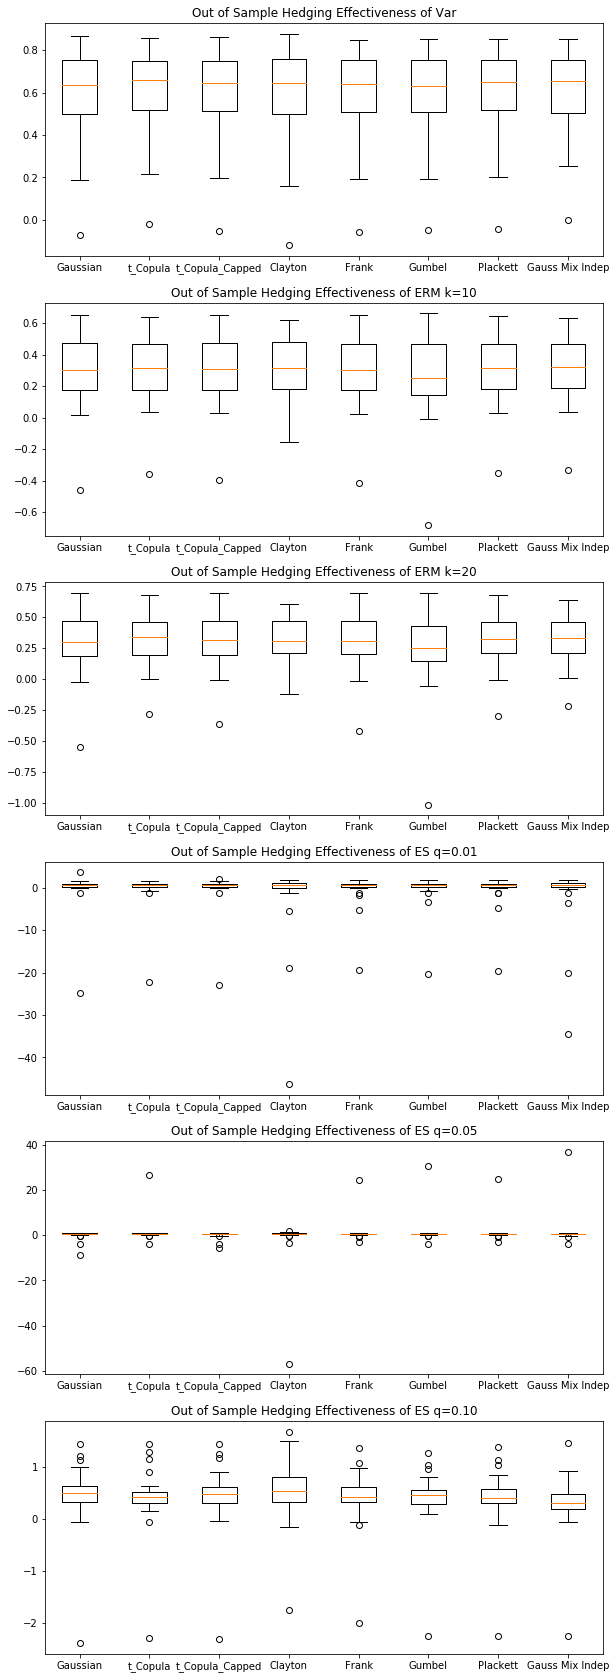

In [26]:
HE_results = []

for i, file in enumerate(ls):
    test = pd.read_csv(data_path+'test/'+file)
    spot   = test.loc[:,spot_name]
    future = test.loc[:,future_name]
    fn = lambda h_arr: hedging_effectiveness(h_arr, spot, future, k_arr, q_arr)
    HE = pd.DataFrame().reindex_like(best_h_results[0])
    HEs = best_h_results[i].apply(fn, axis=1)
    for i in range(len(HEs)):
        HE.iloc[i,:] = HEs[i]
    HE_results.append(HE)
HE_results_pd = pd.concat(dict(zip(ls, HE_results)), axis=1)
risk_measure_names = HE_results_pd.droplevel(0,axis=1).columns.unique()

fig, ax = plt.subplots(len(risk_measure_names), 1, figsize=(10,5*len(risk_measure_names)))
for i, name in enumerate(risk_measure_names): 
    ax[i].boxplot(HE_results_pd.droplevel(0,axis=1).loc[:,name])
#     ax[i].set_xticks(np.linspace(1,len(Copulae_names)))
    ax[i].set_xticklabels(Copulae_names)
    ax[i].set_title("Out of Sample Hedging Effectiveness of %s"%name)
if calibration_method == "MLE":
    fig.savefig("../results/"+ data_name +"/MLE/"+"Out of Sample Hedging Effectiveness.png", transparent=True)    
elif calibration_method == "MM":
    fig.savefig("../results/"+ data_name +"/MM/"+"Out of Sample Hedging Effectiveness.png", transparent=True)